In [1]:
import pandas as pd
import numpy as np
import datetime

In [2]:
import os
from dotenv import load_dotenv

load_dotenv("secret.env")

api_key = os.getenv("MISTRAL_AI_API_KEY")

if api_key is None:
    print("Error: MISTRAL_AI_API_KEY not found in .env file or environment variables.")
else:
    print("MISTRAL_AI_API_KEY loaded successfully.")

MISTRAL_AI_API_KEY loaded successfully.


In [3]:
import os
from mistralai import Mistral

model = "mistral-large-latest"

client = Mistral(api_key=api_key)

In [27]:
prompt = """You are a financial news analyst specializing in stock market impact. Your task is to analyze the provided news article, summarize its core content concisely, determine its sentiment (positive, negative, or neutral), and assess its importance to the specified stock.

Here is the news from stock [STOCK] title and body:
---
[TITLE]
---
[BODY]
---

Please provide your analysis in the following format (Don't forget to make space between the sections as shown):

**Sentiment:**
[Positive / Negative / Neutral]

**Summary:**
[Your concise summary of the article, typically 2-3 sentences.]

**Reasoning for Sentiment:**
[Brief explanation (1-2 sentences) of why you categorized the sentiment as such, referencing key points or tone from the article.]

**Importance to Stock [STOCK]:**
[1-5, where 1 is minimal importance and 5 is very high importance.] (Answer only in number 1-5)

**Reasoning for Importance:**
[Brief explanation (1-2 sentences) of why you assigned this importance score, referencing specific details from the article that would impact the stock.]"""

In [ ]:
df = pd.read_csv("../../DataCollection/Data/Trending/2025-05-27_22-43-20.csv")
display(df.head())

,publish_date,publish_time,title,body_text,url
0,2025-05-27,10:33,US Consumer bounces back sharply in May By Inv...,Investing.com -- Consumer confidence rebounded...,https://www.investing.com/news/economy-news/us...
1,2025-05-27,10:29,Eli Lilly expands pain pipeline with acquisiti...,Investing.com -- Eli Lilly and Company (NYSE: ...,https://www.investing.com/news/stock-market-ne...
2,2025-05-27,09:41,"Lynx: Risk priced in, Nvidia could surprise to...",Investing.com -- Nvidia stock could break out ...,https://www.investing.com/news/stock-market-ne...
3,2025-05-27,09:16,Trump Media & Technology Group Announces $2.5B...,Trump Media and Technology Group Corp. (Nasdaq...,https://www.investing.com/news/cryptocurrency-...
4,2025-05-27,09:15,SoundHound shares jump as Piper Sandler starts...,Investing.com -- Piper Sandler has initiated c...,https://www.investing.com/news/stock-market-ne...


In [29]:
df["title"] = df["title"].astype(str)
df["body_text"] = df["body_text"].astype(str)
df.isnull().sum()

publish_date    0
publish_time    0
title           0
body_text       0
url             0
dtype: int64

In [30]:
from tqdm import tqdm
predicted = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Prompting"):
    
    
    current_stock = row.get("ticker", "news")

    filled_prompt = prompt.replace("[STOCK]", current_stock)
    filled_prompt = filled_prompt.replace("[TITLE]", row["title"])
    filled_prompt = filled_prompt.replace("[BODY]", row["body_text"])
    
    
    response = client.chat.complete(
    model= model,
    messages = [
        {
            "role": "user",
            "content": filled_prompt,
        },
    ]
    )

    predicted.append(response.choices[0].message.content)

Prompting: 100%|██████████| 20/20 [01:36<00:00,  4.83s/it]


In [31]:
predicted = np.array(predicted)
df["predicted"] = predicted

In [32]:
df["sentiment"] = df["predicted"].apply(lambda x: x.split("\n")[1].strip() if len(x.split("\n")) > 1 else None)
df["importance"] = df["predicted"].apply(lambda x: x.split("\n")[10].strip() if len(x.split("\n")) > 10 else None)
df["summary"] = df["predicted"].apply(lambda x: x.split("\n")[4].strip() if len(x.split("\n")) > 4 else None)

In [33]:
df[["title", "sentiment", "importance", "summary"]].head()

,title,sentiment,importance,summary
0,US Consumer bounces back sharply in May By Inv...,Positive,4,Consumer confidence in the U.S. rebounded stro...
1,Eli Lilly expands pain pipeline with acquisiti...,Positive,4,Eli Lilly and Company is acquiring SiteOne The...
2,"Lynx: Risk priced in, Nvidia could surprise to...",Positive,4,Lynx Equity has raised its price target for Nv...
3,Trump Media & Technology Group Announces $2.5B...,Positive,5,Trump Media & Technology Group has secured a $...
4,SoundHound shares jump as Piper Sandler starts...,Positive,4,Piper Sandler initiated coverage on SoundHound...


In [34]:
print(predicted[18])

**Sentiment:**
Positive

**Summary:**
U.S. stocks surged after President Trump delayed EU tariffs and consumer confidence data exceeded expectations. The postponement of tariffs and the start of trade talks with the EU, along with a significant jump in consumer confidence, drove market gains.

**Reasoning for Sentiment:**
The sentiment is positive because the article highlights significant market gains due to the delay of EU tariffs and a substantial increase in consumer confidence, both of which are favorable economic indicators.

**Importance to Stock news:**
4

**Reasoning for Importance:**
The importance is high because the delay of EU tariffs and the start of trade talks reduce trade war risks, and the strong consumer confidence data indicates a positive economic outlook, both of which are crucial for stock market performance.


In [35]:
display(df[df['sentiment']==''])
df = df[df['sentiment'] != '']

,publish_date,publish_time,title,body_text,url,predicted,sentiment,importance,summary


In [37]:
df = df[df['sentiment'].isin(['Positive', 'Negative', 'Neutral'])]
df = df[df['importance'].isin(['1', '2', '3', '4', '5'])]

<Axes: title={'center': 'Sentiment Distribution'}, xlabel='sentiment'>

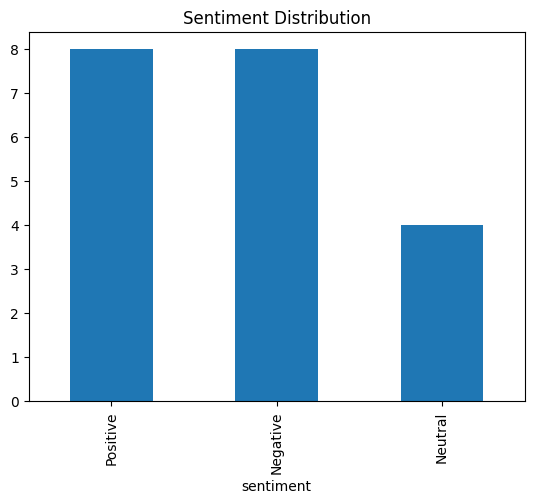

In [38]:
df['sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution')

<Axes: title={'center': 'Importance Distribution'}, xlabel='importance'>

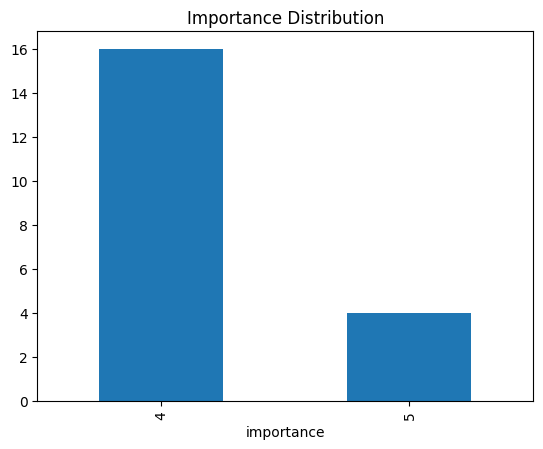

In [39]:
df['importance'].value_counts().sort_index().plot(kind='bar', title='Importance Distribution')

In [40]:
TICKER=current_stock

In [41]:
def calculate_sentiment_score(df):
    sentiment_scores = {
        'Positive': 1,
        'Negative': -1,
        'Neutral': 0
    }
    
    df['sentiment_score'] = df['sentiment'].map(sentiment_scores)
    
    df['weighted_score'] = df['sentiment_score'] * df['importance'].astype(int)
    
    total_importance = df['importance'].astype(int).sum()
    
    if total_importance == 0:
        return 0
    
    sentiment_score = df['weighted_score'].sum() / total_importance
    return sentiment_score

In [42]:
print(f"Sentiment Score for {TICKER}: {calculate_sentiment_score(df).round(2)}")

Sentiment Score for news: -0.02


In [43]:
df.drop(columns=['predicted','body_text'],inplace=True)

In [44]:
import datetime

now = datetime.datetime.now()
date_time = now.strftime("%Y-%m-%d %H-%M-%S").strip().replace(' ', '_')
df.to_csv(f"Output/Mistral/Mistral_{TICKER}_{date_time}.csv", index=False)